In [1]:
# Mount Google Drive if working on Colab

from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [2]:
# Install Required Libraries from PyPI

!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install ISR
!pip install pdf2image
!pip install img2pdf
!sudo apt-get install poppler-utils
!pip install regex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,476 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [3]:
# Import required packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image
import pytesseract as ocr
from ISR.models import RRDN
from google.colab.patches import cv2_imshow
from pdf2image import convert_from_path
import img2pdf

In [4]:
# Load Pretrained ESRGAN Model

SR_Model = RRDN(weights='gans')


17465344/17462488 [==============================] - 1s 0us/step


In [5]:
# Verhoeff Algorithm

multiplication_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 2, 3, 4, 0, 6, 7, 8, 9, 5),
    (2, 3, 4, 0, 1, 7, 8, 9, 5, 6),
    (3, 4, 0, 1, 2, 8, 9, 5, 6, 7),
    (4, 0, 1, 2, 3, 9, 5, 6, 7, 8),
    (5, 9, 8, 7, 6, 0, 4, 3, 2, 1),
    (6, 5, 9, 8, 7, 1, 0, 4, 3, 2),
    (7, 6, 5, 9, 8, 2, 1, 0, 4, 3),
    (8, 7, 6, 5, 9, 3, 2, 1, 0, 4),
    (9, 8, 7, 6, 5, 4, 3, 2, 1, 0))

permutation_table = (
    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    (1, 5, 7, 6, 2, 8, 3, 0, 9, 4),
    (5, 8, 0, 3, 7, 9, 6, 1, 4, 2),
    (8, 9, 1, 6, 0, 4, 3, 5, 2, 7),
    (9, 4, 5, 3, 1, 2, 6, 8, 7, 0),
    (4, 2, 8, 6, 5, 7, 3, 9, 0, 1),
    (2, 7, 9, 3, 8, 0, 6, 4, 1, 5),
    (7, 0, 4, 6, 9, 1, 3, 2, 5, 8))

def compute_checksum(number):
    
    """Calculate the Verhoeff checksum over the provided number. The checksum
    is returned as an int. Valid numbers should have a checksum of 0."""
    
    # transform number list
    number = tuple(int(n) for n in reversed(str(number)))
    
    # calculate checksum
    checksum = 0
    
    for i, n in enumerate(number):
        checksum = multiplication_table[checksum][permutation_table[i % 8][n]]
    
    return checksum

In [6]:
# Search Possible UIDs with Bounding Boxes

def Regex_Search(bounding_boxes):

  possible_UIDs = []
  Result = ""

  for character in range(len(bounding_boxes)):
    if len(bounding_boxes[character])!=0:
      Result += bounding_boxes[character][0]
    else:
      Result += '?'

    #Result += bounding_boxes[character][0]

  matches = [match.span() for match in re.finditer(r'\d{12}',Result,overlapped=True)]

  for match in matches :

    UID = int(Result[match[0]:match[1]])
    
    if compute_checksum(UID)==0 and UID%10000!=1947:
       possible_UIDs.append([UID,match[0]])

  possible_UIDs = np.array(possible_UIDs)
  return possible_UIDs

In [7]:
# Mask found UIDs using OpenCV

def Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rtype,SR=False,SR_Ratio=[1,1]):

  img = cv2.imread(image_path)

  if rtype==2:
    img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
  elif rtype==3:
    img = cv2.rotate(img,cv2.ROTATE_180)
  elif rtype==4:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)

  height = img.shape[0]

  if SR==True:
    height*=SR_Ratio[1]


  for UID in possible_UIDs:

    digit1 = bounding_boxes[UID[1]].split()
    digit8 = bounding_boxes[UID[1] + 7].split()

    h1 = min(height-int(digit1[4]),height-int(digit8[4]))
    h2 = max(height-int(digit1[2]),height-int(digit8[2]))

    if SR==False:
      top_left_corner = (int(digit1[1]),h1)
      bottom_right_corner = (int(digit8[3]),h2)

    else:
      top_left_corner = (int(int(digit1[1])/SR_Ratio[0]),int((h1)/SR_Ratio[1]))
      bottom_right_corner = (int(int(digit8[3])/SR_Ratio[0]),int((h2)/SR_Ratio[1]))

    img = cv2.rectangle(img,top_left_corner,bottom_right_corner,(0,0,0),-1)

  if rtype==2:
    img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  elif rtype==3:
    img = cv2.rotate(img,cv2.ROTATE_180)
  elif rtype==4:
    img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)

  file_name = image_path.split('/')[-1].split('.')[0]+"_masked"+"."+image_path.split('.')[-1]
  cv2.imwrite(file_name,img)
  return file_name

In [8]:
# Extract, Verify and Mask UIDs

def Extract_and_Mask_UIDs (image_path,SR=False,sr_image_path=None,SR_Ratio=[1,1]):

  if SR==False:
    img = cv2.imread(image_path)
  else:
    img = cv2.imread(sr_image_path)

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  rotations = [[gray,1],
               [cv2.rotate(gray,cv2.ROTATE_90_COUNTERCLOCKWISE),2],
               [cv2.rotate(gray,cv2.ROTATE_180),3],
               [cv2.rotate(gray,cv2.ROTATE_90_CLOCKWISE),4],
               [cv2.GaussianBlur(gray,(5,5),0),1],
               [cv2.GaussianBlur(cv2.rotate(gray,cv2.ROTATE_90_COUNTERCLOCKWISE),(5,5),0),2],
               [cv2.GaussianBlur(cv2.rotate(gray,cv2.ROTATE_180),(5,5),0),3],
               [cv2.GaussianBlur(cv2.rotate(gray,cv2.ROTATE_90_CLOCKWISE),(5,5),0),4]]

  settings = ('-l eng --oem 3 --psm 11')

  for rotation in rotations :
    
    cv2.imwrite('rotated_grayscale.png',rotation[0])
    bounding_boxes = ocr.image_to_boxes(Image.open('rotated_grayscale.png'),config=settings).split(" 0\n")

    possible_UIDs = Regex_Search(bounding_boxes)

    if len(possible_UIDs)==0:
      continue
    else:

      if SR==False:
        masked_img = Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rotation[1])
      else:
        masked_img = Mask_UIDs (image_path,possible_UIDs,bounding_boxes,rotation[1],True,SR_Ratio)

      return (masked_img,possible_UIDs)

  return (None,None)

In [9]:
# Test on an Image

input_path = "/drive/My Drive/aadhaar card masking/img2.jpeg"   # Path to the Input Image

if input_path.split('.')[-1]=="pdf":
    
    pages = convert_from_path(input_path, 300)
    pages[0].save('pdf2img.jpg', 'JPEG')

if input_path.split('.')[-1]=="pdf":
  masked_img,possible_UIDs = Extract_and_Mask_UIDs('pdf2img.jpg')
else:
  masked_img,possible_UIDs = Extract_and_Mask_UIDs(input_path)

if masked_img!=None and input_path.split('.')[-1]=="pdf":
    
  image = Image.open(masked_img) 
  pdf_bytes = img2pdf.convert(image.filename) 
  file = open(input_path.split('/')[-1].split('.')[0]+"_masked"+".pdf", "wb")
  masked_img = input_path.split('/')[-1].split('.')[0]+"_masked"+".pdf" 
  file.write(pdf_bytes) 
  image.close() 
  file.close() 

if masked_img==None:
  print("Can't find any UID!")
else:
  print("Found UIDs : "+str(possible_UIDs[:,0]))

Found UIDs : [472894739406 472894739406]



Masked :


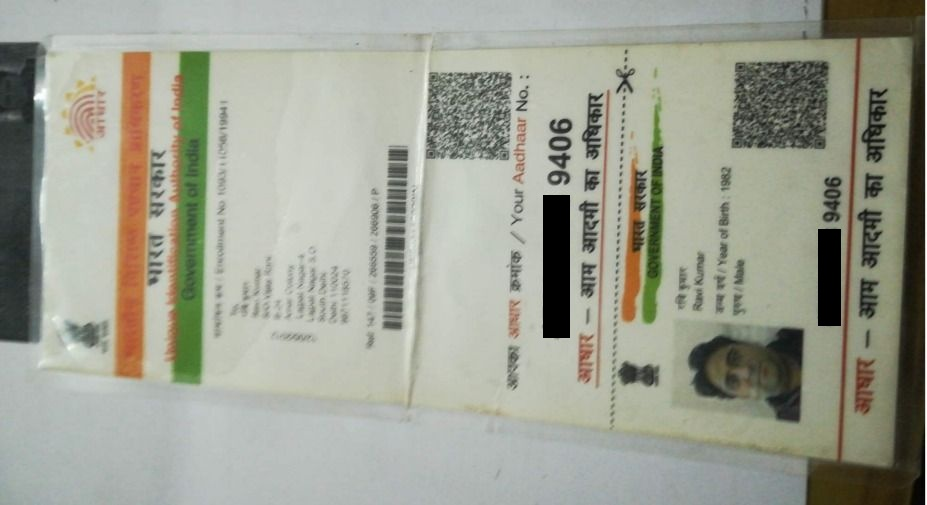

In [10]:
# Show Original and Masked Images (Doesn't work with PDF Files ! Download them instead)

#print("Original :")
#cv2_imshow(cv2.imread(input_path))
print("\nMasked :")
cv2_imshow(cv2.imread(masked_img))

In [ ]:
# Download Masked Image (if required)

from google.colab import files
files.download(masked_img)